In [1]:
import numpy as np
from numpy.random import Generator, PCG64
from deap import base
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

_CONFIG = {
    'init_size': 100,
    'max_size': 1000,
    'n_generations': 50,
    'n_traits': 3,
    'trait_min': -1,
    'trait_max': 1,
    'p_mut': 0.1,
    'mut_std': 0.1,
    'init_opt_gen': np.zeros(3),
    'sel_std': 0.95,
    'warm_rate': 0.01,
    'competition_rate': 0.1,
    'seed': 2137
}

rng = Generator(PCG64(_CONFIG['seed']))

def fitness(population, optimal_traits=_CONFIG['init_opt_gen'], sel_std=_CONFIG['sel_std']):
    distances = np.linalg.norm(population - optimal_traits, axis=1)
    return np.exp(-distances / (2 * sel_std**2))

def mutate(population, p_mut=_CONFIG['p_mut'], mut_std=_CONFIG['mut_std']):

    for _, individual in enumerate(population):    
        if rng.uniform(0, 1) < p_mut:
            ind = rng.integers(0, individual.size)
            mut_val = rng.normal(0, mut_std**2)
            individual[ind] += mut_val

    return population

def reproduce(parents):
    n = len(parents)
    n_half = n // 2
    rng.shuffle(parents)
    group1, group2 = parents[:n_half], parents[n_half:]
    offspring = []
    for p1, p2 in zip(group1, group2):
        child = (p1 + p2) / rng.uniform(2, 4)
        offspring.append(child)
    return offspring

def select_parents(population, fitnesses, comp_rate=_CONFIG['competition_rate']):
    parents = [element for element, prob in zip(population, fitnesses) if rng.uniform(0, 1) < (1 - _CONFIG['competition_rate']) * prob]
    return parents

def init_individual(size=_CONFIG['n_traits'], trait_min=_CONFIG['trait_min'], trait_max=_CONFIG['trait_max']):
    return rng.uniform(trait_min, trait_max, size)

def init_population(pcls, ind_init, size=_CONFIG['init_size']):
    return pcls(ind_init() for _ in range(size))

def global_warming(optimal_traits, warm_rate=_CONFIG['warm_rate']):
    return optimal_traits + rng.uniform(0, warm_rate, _CONFIG['n_traits'])

def meteor_hit(trait_min=_CONFIG['trait_min'], trait_max=_CONFIG['trait_max']):
    return rng.uniform(trait_min, trait_max, _CONFIG['n_traits'])

def simulate_evolution(config):
    toolbox = create_toolbox()
    population = init_population(list, init_individual, config['init_size'])
    optimal_traits = config['init_opt_gen']

    stat_categories = ["population", "fitnesses", "optimal_traits"]
    pop_history = pd.DataFrame(columns=stat_categories, index=np.arange(config['n_generations']))
    history = dict(stat_categories=[])

    for gen in range(config['n_generations']):

        history["population"] = population
        history["optimal_traits"] = optimal_traits

        population = toolbox.mutate(population)
        
        fitnesses = toolbox.evaluate(population, optimal_traits)

        history["fitnesses"] = fitnesses

        parents = toolbox.select(population, fitnesses)

        offspring = toolbox.mate(parents)

        population = parents + offspring

        optimal_traits = global_warming(optimal_traits)

        if rng.uniform(0, 1) < 0.005:
            optimal_traits = meteor_hit()
            print(f"Meteor hit at generation {gen}.")

        pop_history.loc[gen] = history.copy()

        if len(population) > config['max_size']:
            fitnesses = toolbox.evaluate(population, optimal_traits)
            indcs = np.argsort(fitnesses)
            population = [population[i] for i in indcs[:config['max_size']]]

        elif len(population) <= 0:
            print(f"Population died out at generation {gen}.")
            break


    pop_history.dropna(how='all', axis=0, inplace=True)
    return pop_history

def create_toolbox():
    toolbox = base.Toolbox()
    toolbox.register("evaluate", fitness)
    toolbox.register("mate", reproduce)
    toolbox.register("mutate", mutate)
    toolbox.register("select", select_parents)
    return toolbox


In [2]:
import concurrent.futures
from itertools import product

def grid_search_parallel(config, mut_probs, mut_stds, n_simulations=10):
    results = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = []

        for mut_prob, mut_std in product(mut_probs, mut_stds):
            new_config = config.copy()
            new_config['p_mut'] = mut_prob
            new_config['mut_std'] = mut_std
            future = executor.submit(simulate_evolution, new_config)
            futures.append((mut_prob, mut_std, future))

        for mut_prob, mut_std, future in futures:
            pop_history = future.result()
            avg_survival_rate = pop_history.shape[0] / n_simulations
            results.append((mut_prob, mut_std, avg_survival_rate))

    return results

In [3]:
mut_probs = np.linspace(0.1, 0.9, 10)
mut_stds = np.linspace(0.1, 0.9, 10)
results_df = pd.DataFrame(grid_search_parallel(_CONFIG, mut_probs, mut_stds), columns=['p_mut', 'mut_std', 'avg_survival_rate'])

Meteor hit at generation 2.
Population died out at generation 14.
Meteor hit at generation 2.
Meteor hit at generation 2.
Population died out at generation 14.Population died out at generation 14.

Meteor hit at generation 2.
Population died out at generation 14.
Meteor hit at generation 2.
Population died out at generation 14.
Meteor hit at generation 2.
Population died out at generation 14.
Meteor hit at generation 2.
Population died out at generation 14.
Meteor hit at generation 2.
Population died out at generation 14.
Meteor hit at generation 35.
Meteor hit at generation 35.
Meteor hit at generation 35.
Meteor hit at generation 35.
Meteor hit at generation 35.
Meteor hit at generation 35.
Meteor hit at generation 35.
Meteor hit at generation 35.
Meteor hit at generation 25.
Meteor hit at generation 25.
Meteor hit at generation 25.
Meteor hit at generation 25.
Meteor hit at generation 25.
Meteor hit at generation 25.
Meteor hit at generation 25.
Meteor hit at generation 25.
Meteor h

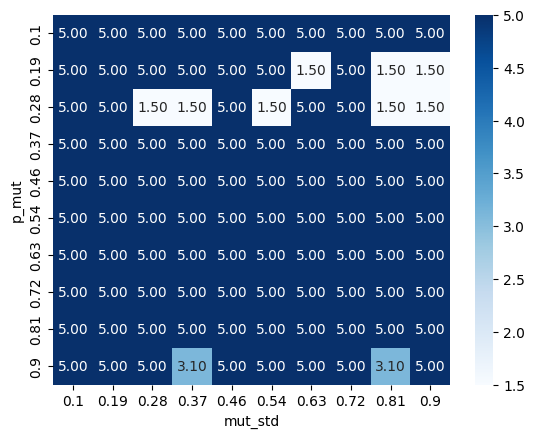

In [4]:
results_df['p_mut'] = results_df['p_mut'].round(2)
results_df['mut_std'] = results_df['mut_std'].round(2)

heatmap = sns.heatmap(results_df.pivot(index='p_mut', columns='mut_std', values='avg_survival_rate'), annot=True, fmt='.2f', cmap='Blues')

plt.show()


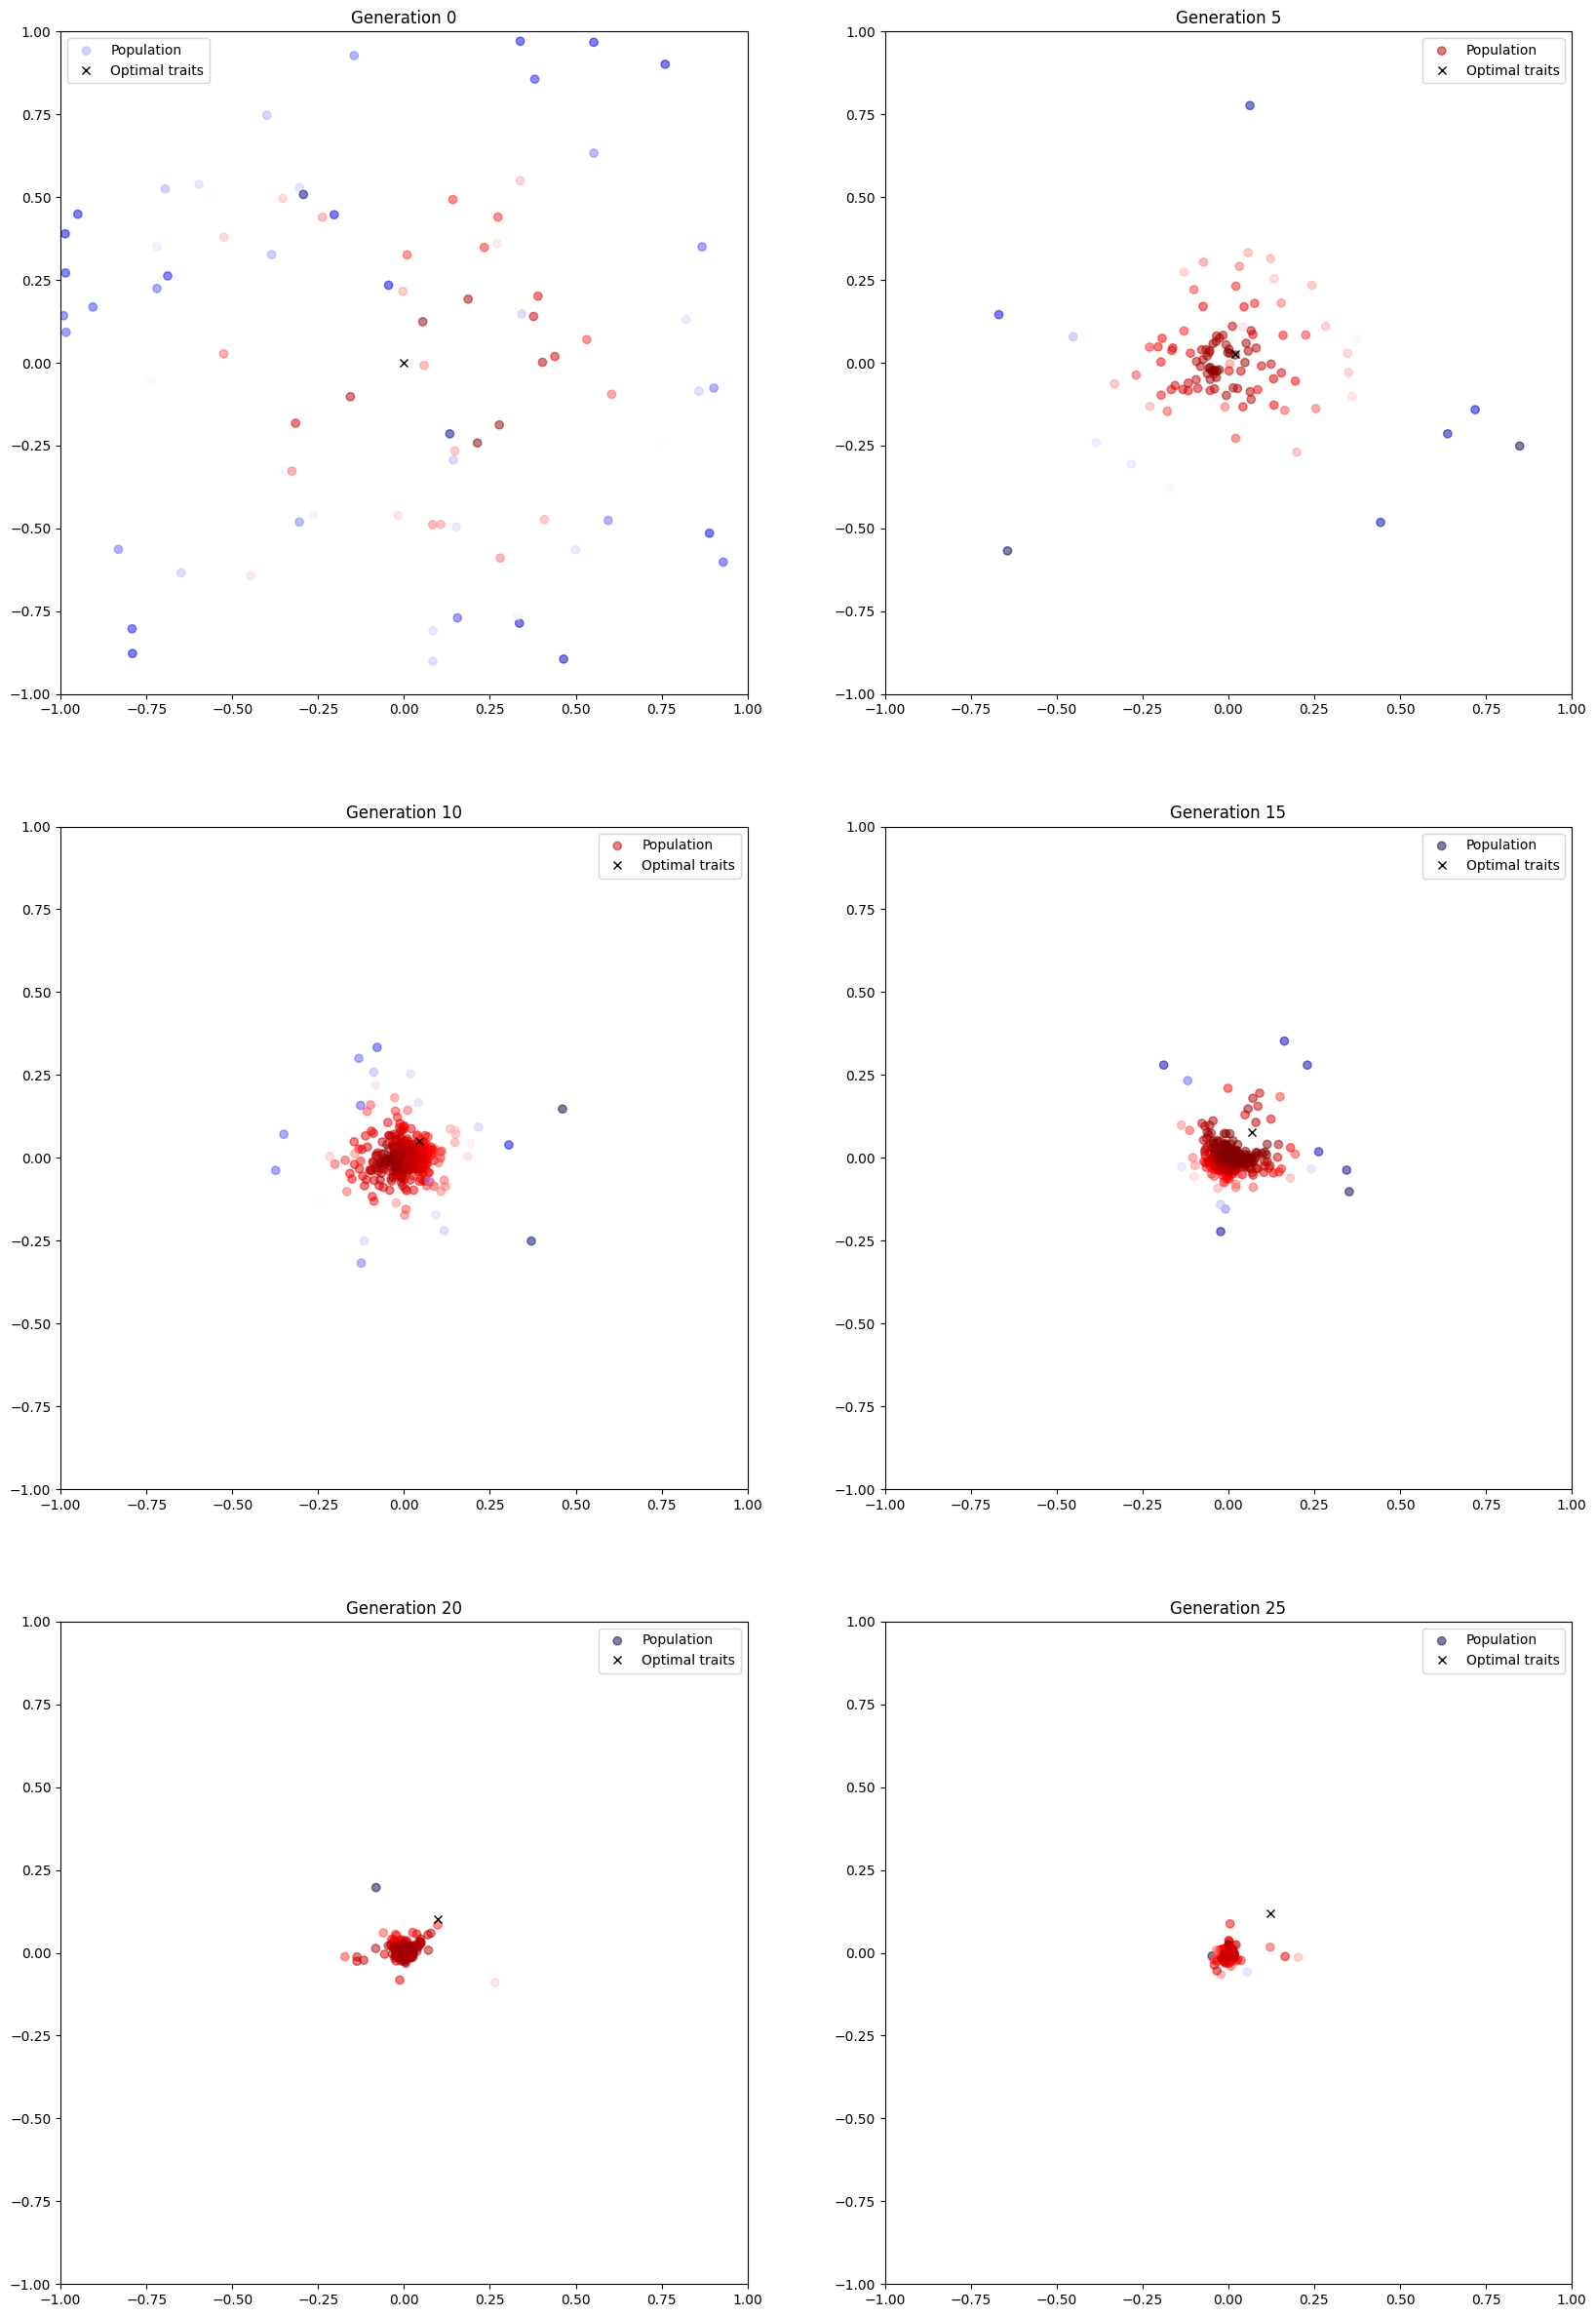

In [5]:
from sklearn.decomposition import PCA

new_config = _CONFIG.copy()
new_config['p_mut'] = 0.5
new_config['mut_std'] = 0.4
new_config['n_generations'] = 26

pop_history = pd.DataFrame()
iter_stop = 0
while pop_history.shape[0] < new_config['n_generations'] and iter_stop < 100:
    pop_history = simulate_evolution(new_config)
    iter_stop += 1

if iter_stop == 100 and pop_history.shape[0] < new_config['n_generations']:
    print("Simulation did not converge.")
else:
    
    pca = PCA(n_components=2)
    pop_history['pca'] = pop_history['population'].apply(lambda x: pca.fit_transform(np.array(x)))

    fig, ax = plt.subplots(3, 2, figsize=(20, 30))
    for (i,j),k in zip(product(range(3), range(2)), range(0, new_config['n_generations'], 5)):
        X, Y = pop_history['pca'][k].T
        ax[i, j].scatter(X, Y, c=pop_history['fitnesses'][k], cmap='seismic', alpha=0.5, label='Population')
        ax[i, j].plot(pop_history['optimal_traits'][k][0], pop_history['optimal_traits'][k][1], 'x', color='black', label='Optimal traits')
        ax[i, j].set_title(f"Generation {k}")
        ax[i, j].set_xlim(-1, 1)
        ax[i, j].set_ylim(-1, 1)
        ax[i, j].legend()




<function matplotlib.pyplot.show(close=None, block=None)>

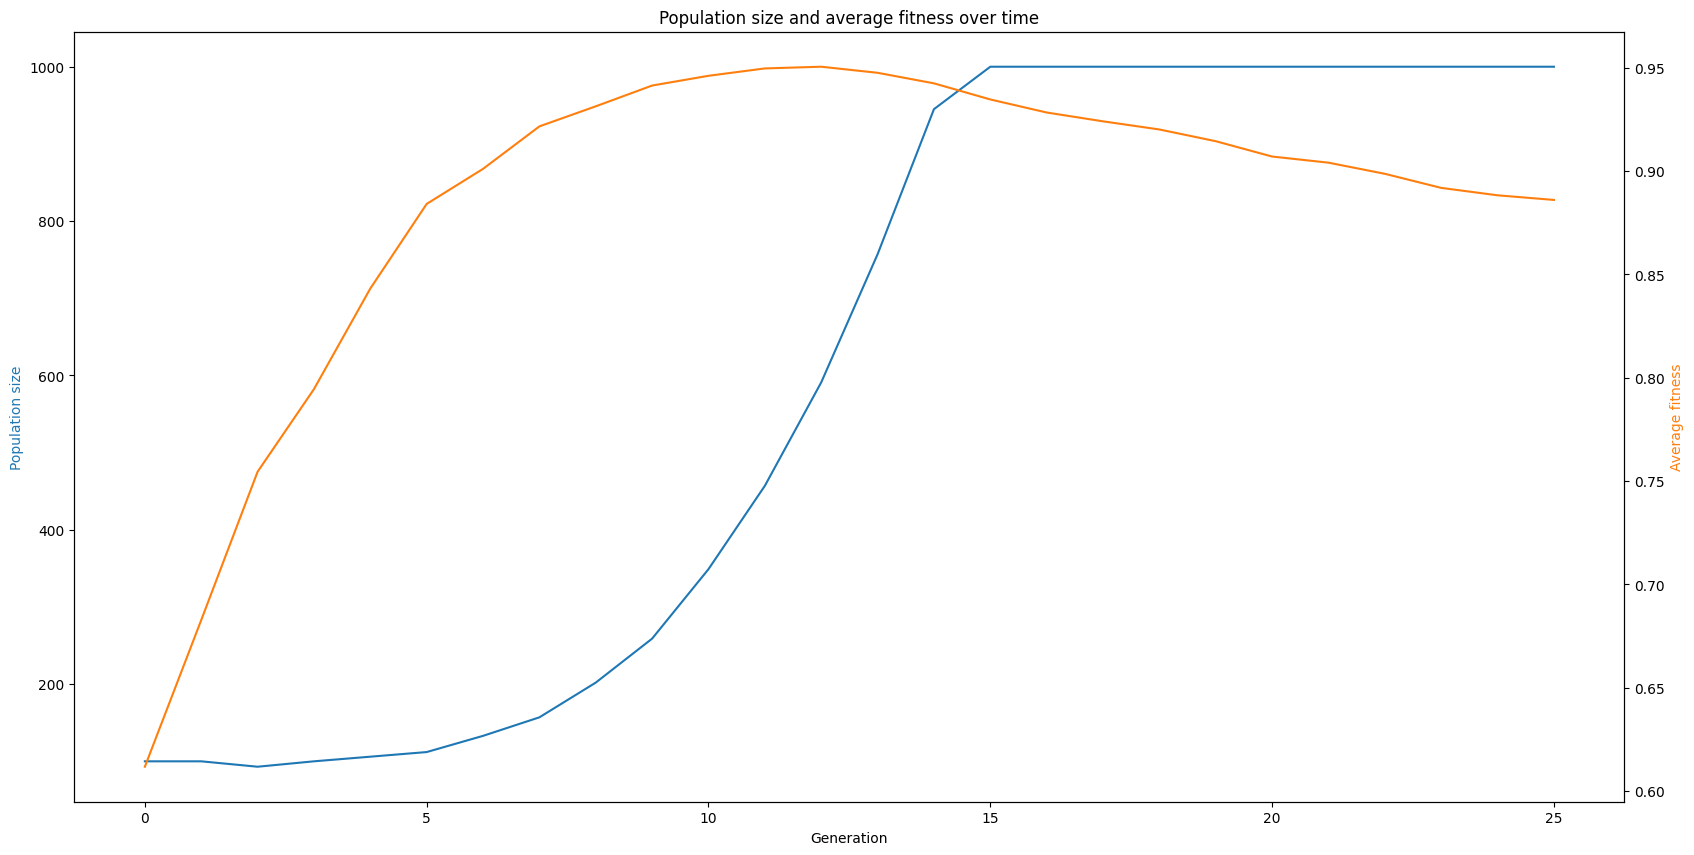

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(pop_history['population'].apply(lambda x: len(x)))
ax2 = ax.twinx()
ax2.plot(pop_history['fitnesses'].apply(lambda x: np.mean(x)), color='tab:orange')
ax.set_title("Population size and average fitness over time")
ax.set_xlabel("Generation")
ax.set_ylabel("Population size", color='tab:blue')
ax2.set_ylabel("Average fitness", color='tab:orange')
plt.show

In [7]:
# Run the simulation
pop_history = simulate_evolution(_CONFIG)

Meteor hit at generation 0.
Population died out at generation 13.
